<a href="https://colab.research.google.com/github/jamahalwin/chicago-crime-analysis/blob/master/Copy_of_ML_Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chicago Crime Analysis**

In [0]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans

In [0]:
dataset_path =  keras.utils.get_file('chicago-crime-sample', 'https://raw.githubusercontent.com/jamahalwin/chicago-crime-analysis/master/Chicago_Crimes_Sample_Data.csv')

In [0]:
raw_dataset = pd.read_csv(dataset_path,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

filter = raw_dataset["Primary_Type"]=="HOMICIDE"

homicides = raw_dataset[filter]

**Lets figure out how many clusters there are**

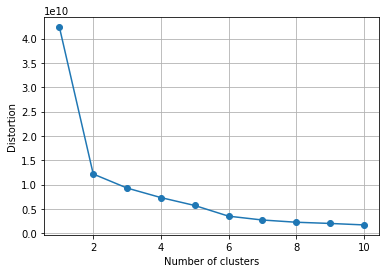

[42341523179.13208,
 12167218993.395115,
 9284336543.380556,
 7324605244.198879,
 5701641855.361616,
 3505405169.08547,
 2716024377.8693085,
 2256473649.45249,
 2009749462.558486,
 1705477863.6555557]

In [0]:
points = homicides.loc[:,['X_Coordinate','Y_Coordinate']]
 
points = points[~np.isnan(points).any(axis=1)]

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(points)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.grid()
plt.show()

distortions

Using the score data we figure out what is the ideal number of clusters for our scatter plots 

In [0]:
previousScore = 0
idealClusterNumber = 0
for i in range(len(distortions)):
  difference = previousScore - distortions[i]
  if difference >= 0.1:
   idealClusterNumber = 6 # 6 is the ideal number. Manually set until you figure out how to automatically do so. 
  previousScore = distortions[i]

In [0]:
# K Means Assignment
km = KMeans(
    n_clusters=idealClusterNumber, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(points)
clusterColors = km.predict(points)

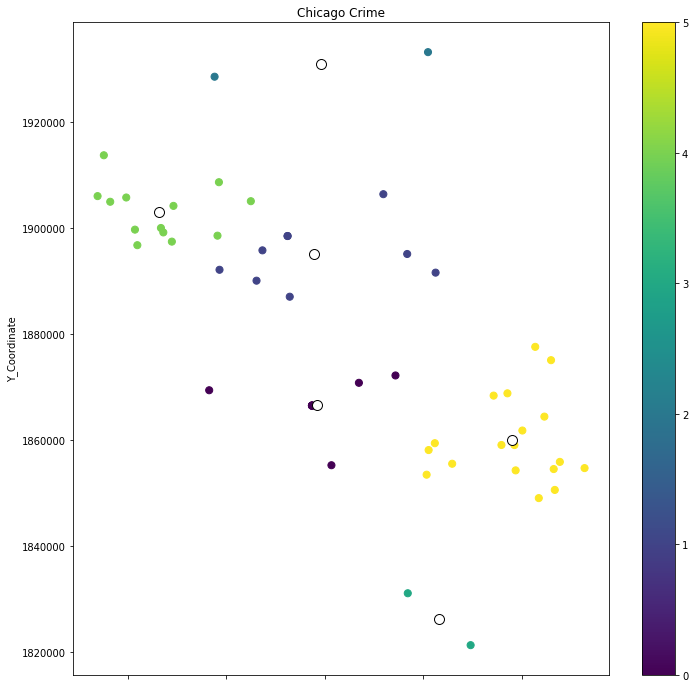

In [0]:
points.plot.scatter(
    x = 'X_Coordinate', 
    y = 'Y_Coordinate', 
    c=clusterColors, 
    s=50, 
    cmap='viridis', 
    figsize=(12,12), 
    title='Chicago Crime')

# Centroids
plt.scatter(
   km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=100,
   c='white', edgecolor='black',
    label='centroids'
)

plt.show()

Showing the data points on a map

In [0]:
import folium as f 

mappoints = homicides.loc[:,['Latitude','Longitude']]
mappoints = mappoints[~np.isnan(mappoints).any(axis=1)]

chicago_map = f.Map(location=[mappoints['Latitude'].iloc[0],mappoints['Longitude'].iloc[0]], zoom_start=10,tiles='Stamen Toner', width='75', height='75%',)

for lat, lon in zip(mappoints['Latitude'], mappoints['Longitude']):
  f.CircleMarker([lat, lon],
                        radius=2,
                       color='red',
                        fill_color='red',
                        popup=('Location: ' + str(lat) + ', ' + str(lon)),
                        fill_opacity=0.7 ).add_to(chicago_map)
chicago_map